# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
tag = 'coding'
homeo_methods = ['None', 'HAP', 'HEH']


record_num_batches = 2**12

seed = 42
np.random.seed(seed)

from shl_scripts.shl_experiments import SHL
shl = SHL()
data = shl.get_data(matname=tag + '_test')
indx = np.random.permutation(data.shape[0])[:record_num_batches]

list_figures = []

dico = {}
for homeo_method in homeo_methods:
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## theory



Sum of non-zero coefficients 53318 ~= 53248
average non-zeros 120.90249433106575 ~= 120.7437641723356


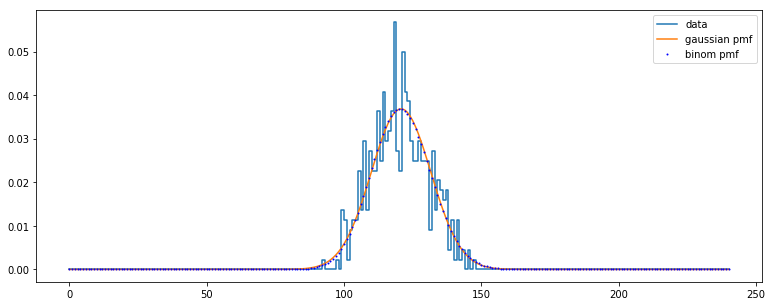

In [4]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

# define the theoretical standard deviation
sd = np.sqrt(rho*(1-rho)*record_num_batches)

# the binomial probability is defined from 0 to record_num_batches \times shl.n_dictionary
# for visualization, we show the part around non-zero probabilities:
#record_num_batches_high = int(rho * record_num_batches + 15. * sd)
record_num_batches_high = int(2. * rho * record_num_batches)
bins = np.arange(record_num_batches_high)

print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
fig, ax= plt.subplots(figsize=(13, 5))
smarts, edges = np.histogram(np.count_nonzero(sparse_code_binary, axis=0), density=True, bins=bins)
smarts /= smarts.sum()
ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data');
#edges_mid = .5*( edges[1:] + edges[:-1] )
#print(rho, s, edges)
proba = np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
proba /= proba.sum()
ax.plot(edges, proba, label='gaussian pmf');
proba_binom = binom.pmf(edges, record_num_batches, rho)
proba_binom /= proba_binom.sum()
ax.plot(edges, proba_binom, 'bo', ms=1, label='binom pmf')
ax.legend()

In [5]:
from shl_scripts.shl_tools import get_logL

In [6]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    logL = get_logL(sparse_code_binary)
    print ('log-likelihood for random sample=', logL.mean(), '+/-', logL.std())


log-likelihood for random sample= -3.7376724162406307 +/- 0.6515582070605965
log-likelihood for random sample= -3.7631641088880383 +/- 0.6365885612755249
log-likelihood for random sample= -3.786860330620101 +/- 0.7128116773568868
log-likelihood for random sample= -3.8411149294497324 +/- 0.7986338577607869
log-likelihood for random sample= -3.7705613565258513 +/- 0.6429981908054959
log-likelihood for random sample= -3.7596370028726054 +/- 0.6249931678364128
log-likelihood for random sample= -3.7405123860615124 +/- 0.5953322953994119
log-likelihood for random sample= -3.777034226800912 +/- 0.6742506830799426
log-likelihood for random sample= -3.8257924374609793 +/- 0.6656509152303305
log-likelihood for random sample= -3.7786288200011793 +/- 0.603534718132044


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SparseHebbianLearning/blob/master/shl_scripts/shl_encode.py) script)

In [7]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    print(42*'🐶')
    print(19*'🐶' + homeo_method + 10*'🐶')
    print(42*'🐶')
    
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, precision=dico[homeo_method].precision, 
#                                              P_cum=dico[homeo_method].P_cum, 
                                              P_cum=None, gain=np.ones(shl.n_dictionary),
                                             l0_sparseness=shl.l0_sparseness, C=shl.C)
    from shl_scripts.shl_tools import print_stats
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method], verbose=False, display=False)
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
average gain of coding =  1.684165828041037 +/- 0.3169102175845568
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
average gain of coding =  1.6855423700042693 +/- 0.3211664141498919
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
average gain of coding =  1.6781187993931004 +/- 0.3134979285542611


In [8]:
sparse_code[homeo_method].shape

(4096, 441)

🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶Non🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Average of non-zero coefficients 0.02942531179138322 ~= 0.02947845804988662
Mean of non-zero coefficients 120.52607709750566 ~= 120.7437641723356
Mean of non-zero coefficients 120.52607709750566 +/- 18.59558563868739
Median of non-zero coefficients 120.0
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Average of non-zero coefficients 0.029427526218820863 ~= 0.02947845804988662
Mean of non-zero coefficients 120.53514739229026 ~= 120.7437641723356
Mean of non-zero coefficients 120.53514739229026 +/- 16.927463309483844
Median of non-zero coefficients 120.0
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
Average of non-zero coefficients 0.029413686047335602 ~= 0.02947845804988662
Mean of non-zero coefficients 120.47845804988663 ~=

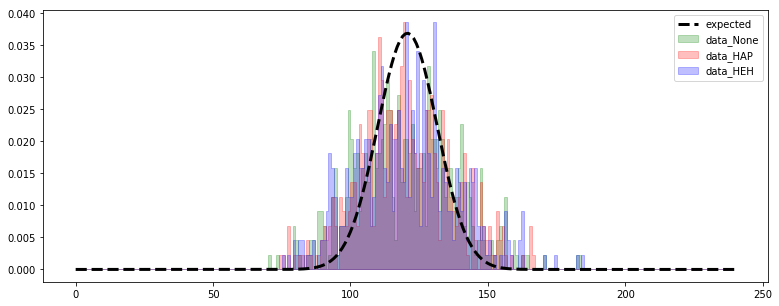

In [9]:
rho = shl.l0_sparseness / shl.n_dictionary
sd = np.sqrt(rho*(1-rho)*record_num_batches)

fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method, color in zip(homeo_methods, ['g', 'r', 'b']):
    print(42*'🐶')
    print(15*'🐶' + homeo_method[:3] + 15*'🐶')
    print(42*'🐶')
    print('Average of non-zero coefficients', (sparse_code[homeo_method]>0).mean(), '~=', rho)
    n_i = np.count_nonzero(sparse_code[homeo_method], axis=0)
    print('Mean of non-zero coefficients', n_i.mean(), '~=', rho*record_num_batches)
    print('Mean of non-zero coefficients', n_i.mean(), '+/-', n_i.std())
    print('Median of non-zero coefficients', np.median(n_i))
    smarts, edges = np.histogram(n_i, density=True, bins=bins)
    smarts /= smarts.sum()
    # ax.step(edges, np.hstack((smarts, 0)), where='pre', label='data_' + homeo_method);
    ax.fill_between(edges[:-1], smarts, step='pre', label='data_' + homeo_method, alpha=.25, color=color);

proba = 1 / np.sqrt(2*np.pi) / sd *  np.exp(-.5 * (edges - rho*record_num_batches)**2 / sd**2)
#proba /= proba.sum()
ax.plot(edges, proba, 'k--', label='expected', lw=3)
ax.legend();

## measuring the distance to independance 

In [10]:

#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    logL = get_logL(sparse_code[homeo_method])
    print ('log-likelihood for  ', homeo_method, 'is', logL.mean(), '+/-', logL.std())
    #ax.vline(edges, proba, label=homeo_method)

logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
print ('log-likelihood for theory is', logL.mean(), '+/-', logL.std())
#for _ in range(10):
#    logL = get_logL(np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho)
#ax.plot(edges, proba, label='theory')
#ax.legend();

log-likelihood for   None is -4.777956207550441 +/- 2.066603975411315
log-likelihood for   HAP is -4.524624926666446 +/- 1.7298894038012385
log-likelihood for   HEH is -4.743077739465025 +/- 2.113461232982929
log-likelihood for theory is -3.766056288801335 +/- 0.7308084852046445


## Version used

In [11]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,shl_scripts

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]
IPython 6.5.0
OS Darwin 17.7.0 x86_64 i386 64bit
shl_scripts 20171221
numpy 1.15.1
shl_scripts 20171221
pandas 0.23.4
matplotlib 3.0.0
Wed Sep 26 16:36:18 2018 CEST